<a href="https://colab.research.google.com/github/monicasjsu/Emerging-Software-Technologies/blob/master/Assignment_4/MetaLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Meta Learning using omniglot dataset**


**Meta Learning**: It is known as learning how to learn. It is a potential learning paradigm that can absorb information from one task and generalize that information to unseen tasks proficiently




In [3]:
!pip install tensorflow==1.13.1

In [4]:
import os
import glob
from PIL import Image

import numpy as np
import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


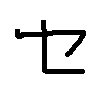

In [6]:
Image.open('/content/drive/My Drive/Datasets/data/data/images/Japanese_(katakana)/character13/0608_01.png')

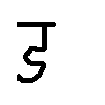

In [7]:
Image.open('/content/drive/My Drive/Datasets/data/data/images/Sanskrit/character13/0863_09.png')

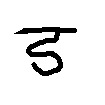

In [8]:
Image.open('/content/drive/My Drive/Datasets/data/data/images/Sanskrit/character13/0863_13.png')

Converting the image to array using `np.array`

In [9]:
image_name = '/content/drive/My Drive/Datasets/data/data/images/Sanskrit/character13/0863_13.png'
alphabet, character, rotation = 'Sanskrit/character13/rot000'.split('/')
rotation = float(rotation[3:])

In [10]:
np.array(Image.open(image_name).rotate(rotation).resize((28, 28)), np.float32,copy=True)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1

Load the dataset

In [11]:
root_dir = '/content/drive/My Drive/Datasets/data/data/'

In [12]:
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')

with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]

In [13]:
#number of classes
no_of_classes = len(train_classes)

In [14]:
#number of examples
num_examples = 20

#image width
img_width = 28

#image height
img_height = 28
channels = 1

In [15]:
train_dataset = np.zeros([no_of_classes, num_examples, img_height, img_width], dtype=np.float32)

In [16]:
for label, name in enumerate(train_classes):
    alphabet, character, rotation = name.split('/')
    rotation = float(rotation[3:])
    img_dir = os.path.join(root_dir, 'data', alphabet, character)
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
  
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).rotate(rotation).resize((img_width, img_height)), np.float32, copy=False)
        train_dataset[label, index] = values

In [17]:
train_dataset.shape

(4112, 20, 28, 28)

In [18]:
def convolution_block(inputs, out_channels, name='conv'):

    conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
    conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.contrib.layers.max_pool2d(conv, 2)
    
    return conv

In [19]:
def get_embeddings(support_set, h_dim, z_dim, reuse=False):

        net = convolution_block(support_set, h_dim)
        net = convolution_block(net, h_dim)
        net = convolution_block(net, h_dim) 
        net = convolution_block(net, z_dim) 
        net = tf.contrib.layers.flatten(net)
        
        return net

In [20]:
num_way = 60  

#number of examples per class for support set
num_shot = 5  

#number of query points
num_query = 5 

#number of examples
num_examples = 20

h_dim = 64

z_dim = 64

In [21]:
support_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])
query_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])

In [22]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)

In [23]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [24]:
num_query_points = query_set_shape[1]

In [25]:
y = tf.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)

In [26]:
support_set_embeddings = get_embeddings(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channels]), h_dim, z_dim)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


In [27]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]

class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [28]:
query_set_embeddings = get_embeddings(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channels]), h_dim, z_dim, reuse=True)

Define a distance function which gives us the distance between the class prototypes and query set embeddings

In [29]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

Calculating the distance between the class prototype and query set embeddings

In [30]:
distance = euclidean_distance(class_prototype,query_set_embeddings)

In [31]:
predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])

Compute the loss

In [32]:
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

Calculate the accuracy

In [ ]:
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predicted_probability, axis=-1), y)))

Using Adam Optimizer to minimize the loss

In [34]:
train = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.cast instead.


Train the model by starting the tensorflow session

In [35]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [36]:
num_epochs = 20
num_episodes = 100

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = train_dataset[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = train_dataset[class_, selected[num_shot:]]
            
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 20 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 30 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 40 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 50 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
